In [1]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
import myUtils as utils

rootPath = "../../results/scenario/h22"
pathTail = "/networks/base_s_27_3H_3H_2045.nc"



plt.style.use('bmh')
%matplotlib inline

nBase = pypsa.Network(f"../../results/scenario/base{pathTail}")
nMean = pypsa.Network(f"{rootPath}_mean/{pathTail}")
nGood = pypsa.Network(f"{rootPath}_good/{pathTail}")
nBest = pypsa.Network(f"{rootPath}_best/{pathTail}")

networks = {
  # "Basis": nBase,
  "Mittel": nMean,
  "Optimistisch": nGood,
  "Sehr Optimistisch": nBest
}

INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


  [SMR], [0,00], [0,00], [0,00], [0,00],
  [Import], [141,12], [71,33], [148,31], [130,86],
  [Elektrolyse], [209,30], [207,08], [209,33], [221,12],
  [Wasserstoff zu Strom], [-0,00], [-23,98], [-34,41], [-38,39],
  [Industrie], [-35,97], [-35,97], [-35,97], [-35,97],
  [Export], [-14,88], [-12,51], [-17,01], [-30,50],
  [Fischer-Tropsch], [-299,55], [-241,37], [-306,63], [-270,14],


Text(0, 0.5, 'Energie in Gigawattstunden')

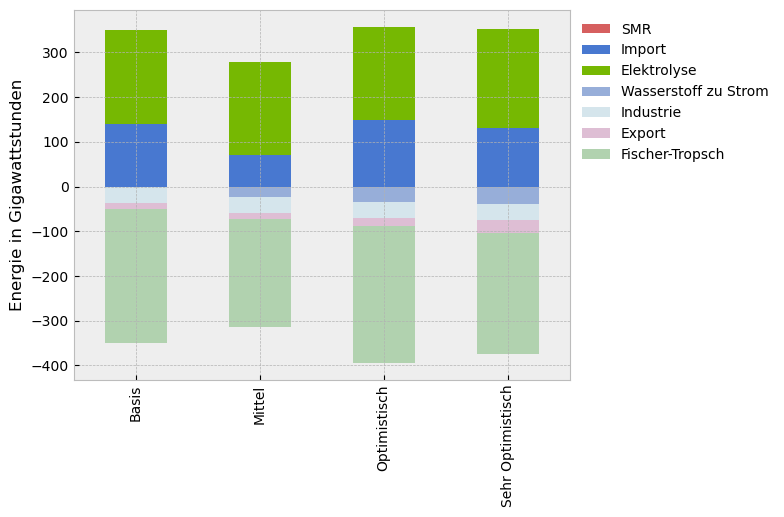

In [9]:
import pandas as pd
import myUtils as utils
import importlib
importlib.reload(utils)

import seaborn as sns
plt.style.use('seaborn-v0_8-muted')
sns.color_palette("muted")

df = pd.DataFrame()
for key, n in networks.items():
  s = pd.Series()
  h2Dispatch =  - utils.getNTimePropByGroup(n, 'Link','p0', utils.de_h2_dispatch_grouper).sum().sum() * 3
  h2FT = - utils.getNTimePropByGroup(n, 'Link','p0', utils.de_h2_FT_grouper).sum().sum() * 3 
  h2M = - utils.getNTimePropByGroup(n, 'Link','p0', utils.de_h2_use_grouper).sum().sum() * 3

  h2Industry = - utils.getNTimePropByGroup(n, 'Load','p', utils.de_h2_industry_grouper).sum().sum() * 3
  h2Export = - utils.getNTimePropByGroup(n, 'Link','p0', utils.de_export_h2_grouper).sum().sum() * 3
  
  h2Import = - utils.getNTimePropByGroup(n, 'Link','p1', utils.de_import_h2_grouper).sum().sum() * 3
  h2Electrolysis = - utils.getNTimePropByGroup(n, 'Link','p1', utils.de_h2_Electrolysis_grouper).sum().sum() * 3
  h2SMR = - utils.getNTimePropByGroup(n, 'Link','p1', utils.de_h2_SMR_grouper).sum().sum() * 3


  s['SMR'] = h2SMR
  s['Import'] = h2Import  
  s['Elektrolyse'] = h2Electrolysis

  s['Wasserstoff zu Strom'] = h2Dispatch
  s['Industrie'] = h2Industry
  s['Export'] = h2Export
  s['Fischer-Tropsch'] = h2FT
  # s['Methanolisierung'] =   - (h2Electrolysis + h2Import + h2SMR + h2Dispatch + h2Industry + h2Export + h2FT )
  
  # # df = df.set_index('Tech')
  df[key] = s

# df.insert(0, 'unit', ['GW_LHV', 'TWH_LHV', 'TWH_LHV', 'TWH_LHV', 'TWH_LHV', 'TWH_LHV', 'TWH_LHV' ])
df = df / 1e6
print(utils.dataframe_to_table(df))

colors = {
  'Import': '#4878D0',
  'SMR': '#D65F5F',
  'Elektrolyse': '#76B802',
  

  'Wasserstoff zu Strom': '#97AED9',
  'Industrie': '#D5E5EC',
  'Export': '#DEBED4',
  'Fischer-Tropsch': '#B1D2AF',
  'Methanolisierung': '#F4C9B0',
}


ax = df.T.plot(kind='bar', stacked=True, color=colors)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, frameon=False)
# ax.set_xlabel('')
ax.set_ylabel('Energie in Gigawattstunden')



# plt.show()

<Axes: xlabel='snapshot'>

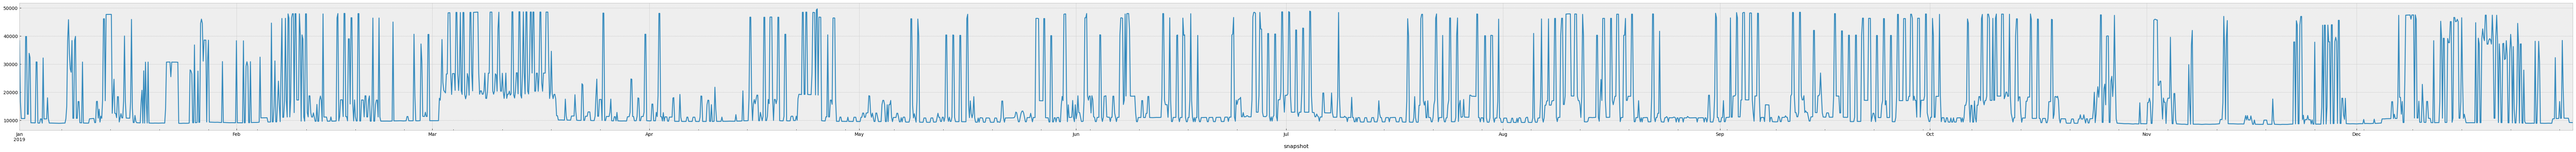

In [29]:
biogasImportP =  utils.getNTimePropByGroup(n, 'Generator','p', utils.de_gas_generator).sum(axis=1) - utils.getNTimePropByGroup(n, 'Link','p1', utils.de_gas_pipeline_import).sum(axis=1)
biogasImportP.plot(figsize=(100,5))

In [17]:
for key, n in networks.items():
  print(n.statistics.withdrawal(groupby=['carrier', 'de_gas_use']).groupby('carrier').sum() / 1e6)

carrier
Open-Cycle Gas                1.83774
SMR                           0.00003
SMR CC                        0.00004
gas for industry              0.00028
gas for industry CC          83.64414
rural gas boiler              4.26349
urban central CHP            25.47542
urban central CHP CC          0.00009
urban central gas boiler     11.63690
urban decentral gas boiler   23.47542
dtype: float64
carrier
Open-Cycle Gas                2.42090
SMR                           0.00005
SMR CC                        0.00010
gas for industry              0.00009
gas for industry CC          83.64434
rural gas boiler              7.06789
urban central CHP            26.77789
urban central CHP CC          0.00015
urban central gas boiler     19.68138
urban decentral gas boiler   37.93302
dtype: float64
carrier
Open-Cycle Gas                2.42082
SMR                           0.00006
SMR CC                        0.00010
gas for industry              0.00010
gas for industry CC          83.64

In [5]:
from pea import Pea, carriers as cs


%load_ext autoreload
%autoreload 2

df = pd.DataFrame()

for key, n in networks.items():
  pea = Pea(n)
  s = pd.Series()
  s['Wasserstoffspeicherung CAPEX'] = pea.get(cs.h2FC).capex() / 1e3
  s['Wasserstoffturbine CAPEX'] = pea.get(cs.h2Turbine).capex() / 1e3
  s['Wasserstoff-Brennstoffzelle CAPEX'] = pea.get(cs.h2FC).capex() / 1e3

  s['Wasserstoffspeicherung Kapazität'] = pea.get(cs.h2Turbine).p_nom_opt() / 1e3
  s['Wasserstoffturbine Kapazität'] = pea.get(cs.h2Turbine).p_nom_opt() / 1e3
  s['Wasserstoff-Brennstoffzelle Kapazität'] = pea.get(cs.h2FC).p_nom_opt() / 1e3

  s['Wasserstoffspeicherung Stromerzeugung'] = pea.get(cs.h2Turbine).energy('p1') / 1e6
  s['Wasserstoffturbine Stromerzeugung'] = pea.get(cs.h2Turbine).energy('p1') / 1e6
  s['Wasserstoff-Brennstoffzelle Stromerzeugung'] = pea.get(cs.h2FC).energy('p1') / 1e6

  df[key] = s

print(utils.dataframe_to_table(df))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
  [Wasserstoffspeicherung CAPEX], [712,523], [651,948], [345,592],
  [Wasserstoffturbine CAPEX], [155,955], [124,764], [77,978],
  [Wasserstoff-Brennstoffzelle CAPEX], [712,523], [651,948], [345,592],
  [Wasserstoffspeicherung Kapazität], [87,525], [125,564], [136,200],
  [Wasserstoffturbine Kapazität], [87,525], [125,564], [136,200],
  [Wasserstoff-Brennstoffzelle Kapazität], [0,000], [0,000], [8,055],
  [Wasserstoffspeicherung Stromerzeugung], [3,397], [4,874], [3,895],
  [Wasserstoffturbine Stromerzeugung], [3,397], [4,874], [3,895],
  [Wasserstoff-Brennstoffzelle Stromerzeugung], [0,000], [0,000], [1,998],


In [11]:
pea = Pea(nBest)
pea.get(cs.h2FC).df['p_nom_opt'].sum()/1e3

8.054716744886402